In [7]:
import numpy as np
ECG=np.load('ECG_example.npy')
ECG.shape# instance, lead, samples 

(2, 12, 5000)

In [1]:
from custom_dataset import FinalDataset
dataset = FinalDataset("./data/Dataset.hdf5")

In [ ]:
import numpy as np
import torch
import wfdb
from wfdb import processing
from scipy.signal import butter, filtfilt, correlate, correlation_lags

# Constants
Fs = 400  # Sampling frequency
i_left = int(20e-3 * Fs)
i_right = int(50e-3 * Fs)
pq = int(0.08 * Fs)
qt = int(0.10 * Fs)
max_lag = 0.9

# Bandpass filter function
def filter_signal(ecg, fs):
    b, a = butter(3, [0.5 * 2 / fs, 40 * 2 / fs], btype='bandpass')
    return filtfilt(b, a, ecg, axis=0)

# Woody correction
def woody(ecg, q_indices, i_left, i_right):
    vm = np.sqrt(np.sum(ecg**2, axis=1))
    segment_len = i_left + i_right
    beats = np.full((len(q_indices), segment_len), np.nan)

    for i, q in enumerate(q_indices):
        start = max(0, q - i_left)
        end = min(len(vm), q + i_right)
        segment = vm[start:end]
        beats[i, :len(segment)] = segment

    template = np.nanmean(beats, axis=0)
    correlations = np.array([correlate(template, beat, mode="full") for beat in beats])
    lags = correlation_lags(template.size, segment_len, mode="full")
    delays = lags[np.argmax(correlations, axis=1)]
    
    return np.where(delays < 0, q_indices + np.abs(delays), q_indices - delays)

# Main ECG processing
def process_ecg(ecg_data, fs):
    results = []
    for idx, (ecg,label) in enumerate(ecg_data):
        banned_idx = [739, 4157, 4629,5510,6470,6896,7305]
        if idx in banned_idx:
            continue
        # if idx % 1000 == 0:
        print(f"N° {idx}")
            
        # convert to numpy array from tensor
        if isinstance(ecg, torch.Tensor):
            ecg = ecg.numpy()
        # ecg_filtered = filter_signal(ecg, fs)
        qrs_inds = processing.gqrs_detect(ecg[:, 0], fs=fs)
        
        if qrs_inds.size > 0:
            corrected_peaks = processing.peaks.correct_peaks(
                ecg[:, 0], peak_inds=qrs_inds,
                search_radius=int(fs * 90 / 230), smooth_window_size=130
            )
            q_corrected = woody(ecg, corrected_peaks, i_left, i_right)
            leads = ecg.shape[1]
            avg_beat = np.full((leads, pq + qt), np.nan)

            for lead in range(leads):
                beats = np.full((len(q_corrected), pq + qt), np.nan)
                for i, q in enumerate(q_corrected):
                    start = max(0, q - pq)
                    end = min(len(ecg), q + qt)
                    beat = ecg[start:end, lead]
                    beats[i, :len(beat)] = beat
                avg_beat[lead, :] = np.nanmean(beats, axis=0) if not np.all(np.isnan(beats)) else np.nan

            results.append(avg_beat)
        else:
            print(f"No QRS detected for instance {idx}")
            results.append(None)
    return results


average_beats = process_ecg(dataset, Fs)


N° 0
N° 1
N° 2
N° 3
N° 4
N° 5
N° 6
N° 7
N° 8
N° 9
N° 10
N° 11
N° 12
N° 13
N° 14
N° 15
N° 16
N° 17
N° 18
N° 19
N° 20
N° 21
N° 22
N° 23
N° 24
N° 25
N° 26
N° 27
N° 28
N° 29
N° 30
N° 31
N° 32
N° 33
N° 34
N° 35
N° 36
N° 37
N° 38
N° 39
N° 40
N° 41
N° 42
N° 43
N° 44
N° 45
N° 46
N° 47
N° 48
N° 49
N° 50
N° 51
N° 52
N° 53
N° 54
N° 55
N° 56
N° 57
N° 58
N° 59
N° 60
N° 61
N° 62
N° 63
N° 64
N° 65
N° 66
N° 67
N° 68
N° 69
N° 70
N° 71
N° 72
N° 73
N° 74
N° 75
N° 76
N° 77
N° 78
N° 79
N° 80
N° 81
N° 82
N° 83
N° 84
N° 85
N° 86
N° 87
N° 88
N° 89
N° 90
N° 91
N° 92
N° 93
N° 94
N° 95
N° 96
N° 97
N° 98
N° 99
N° 100
N° 101
N° 102
N° 103
N° 104
N° 105
N° 106
N° 107
N° 108
N° 109
N° 110
N° 111
N° 112
N° 113
N° 114
N° 115
N° 116
N° 117
N° 118
N° 119
N° 120
N° 121
N° 122
N° 123
N° 124
N° 125
N° 126
N° 127
N° 128
N° 129
N° 130
N° 131
N° 132
N° 133
N° 134
N° 135
N° 136
N° 137
N° 138
N° 139
N° 140
N° 141
N° 142
N° 143
N° 144
N° 145
N° 146
N° 147
N° 148
N° 149
N° 150
N° 151
N° 152
N° 153
N° 154
N° 155
N° 156
N° 157
N° 1

ValueError: could not broadcast input array from shape (3973,) into shape (28,)

In [22]:
filtered_beats = [beat for beat in average_beats if beat is not None]
len(filtered_beats)

0

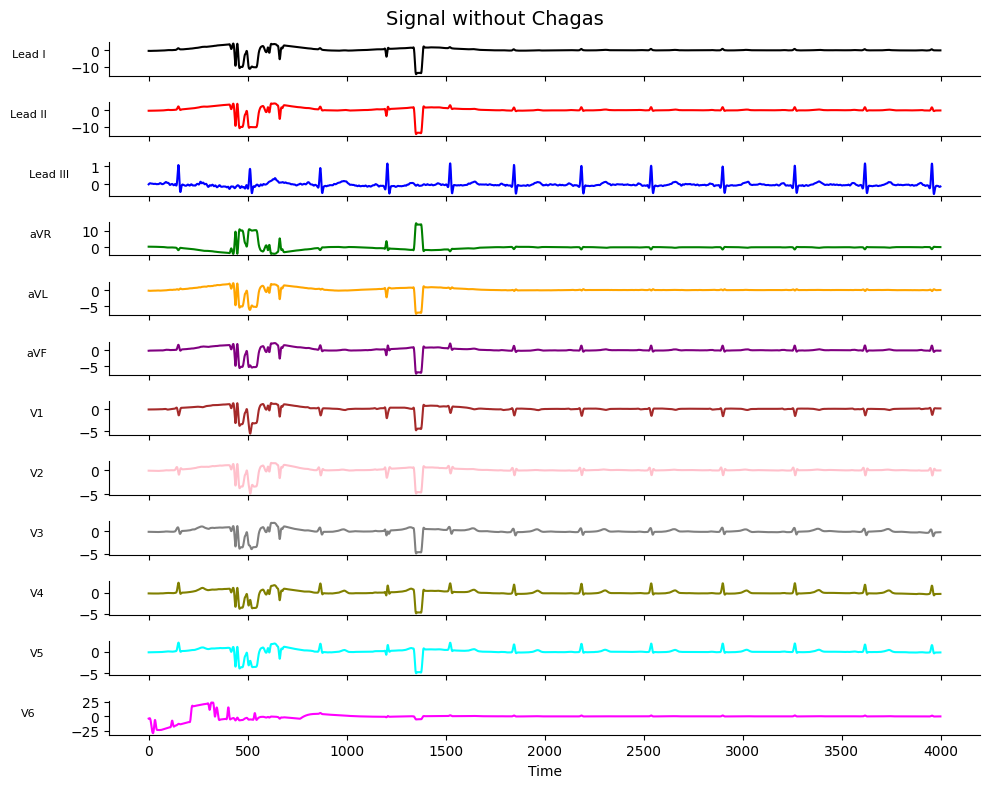

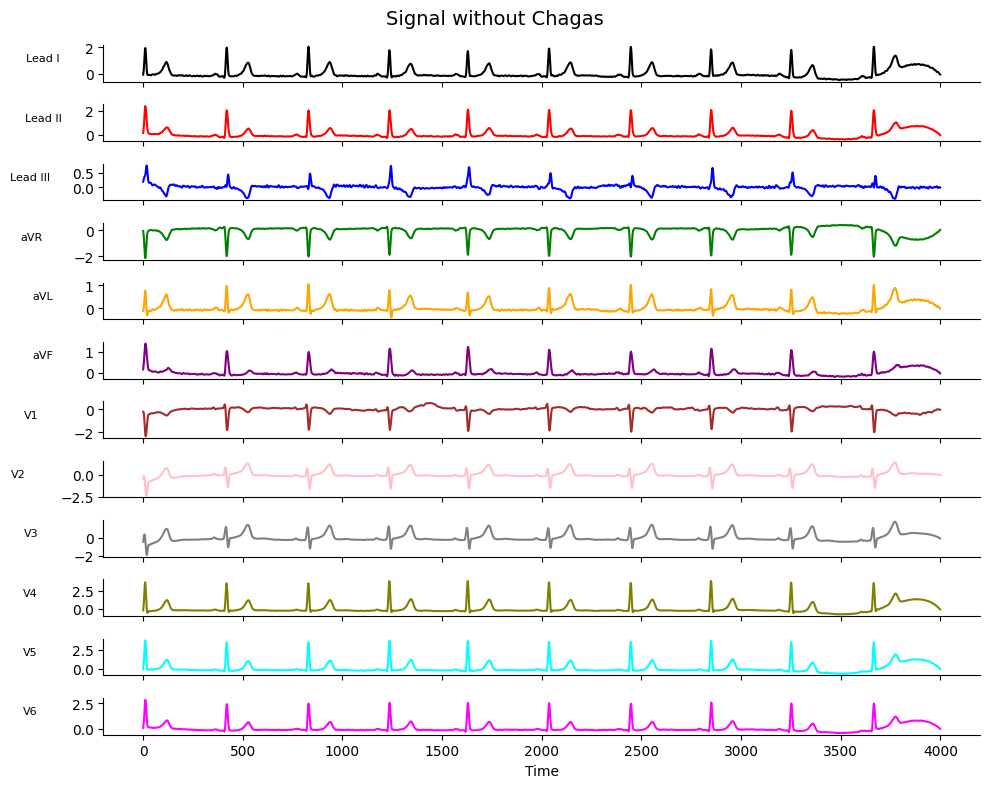

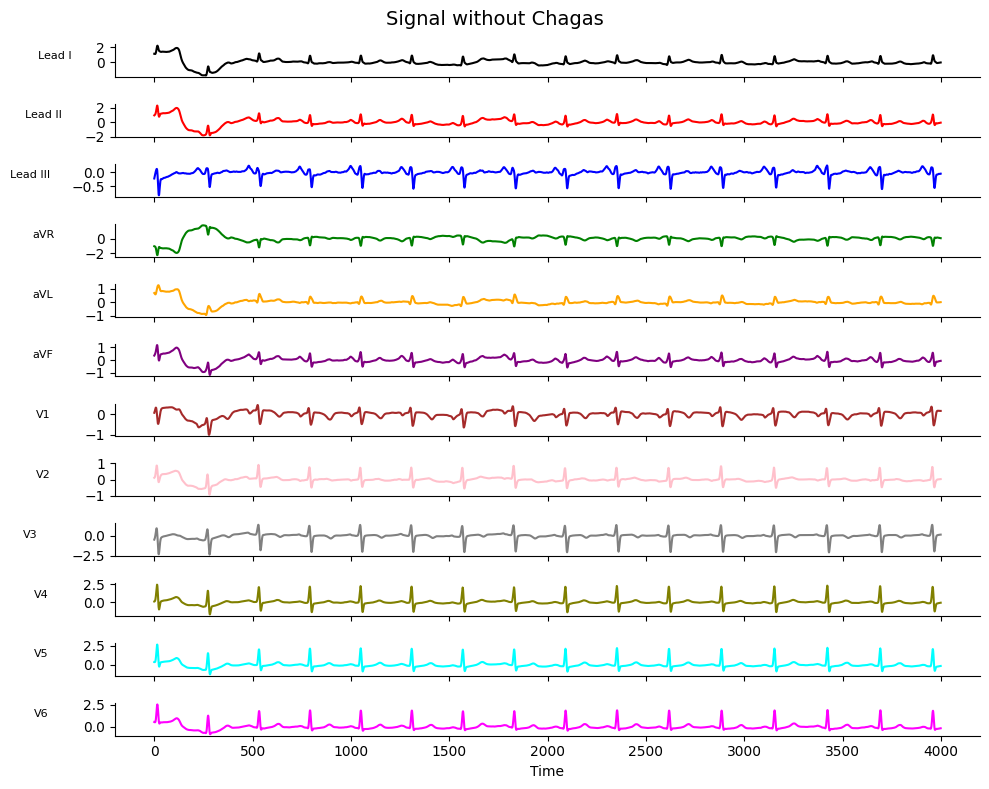

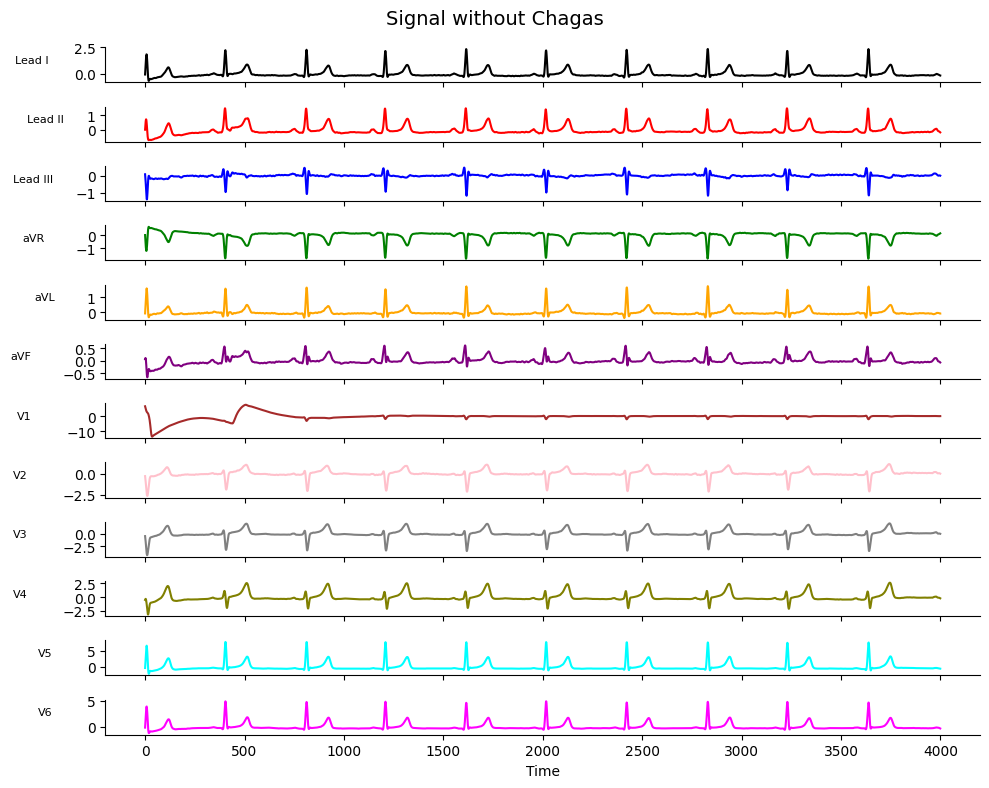

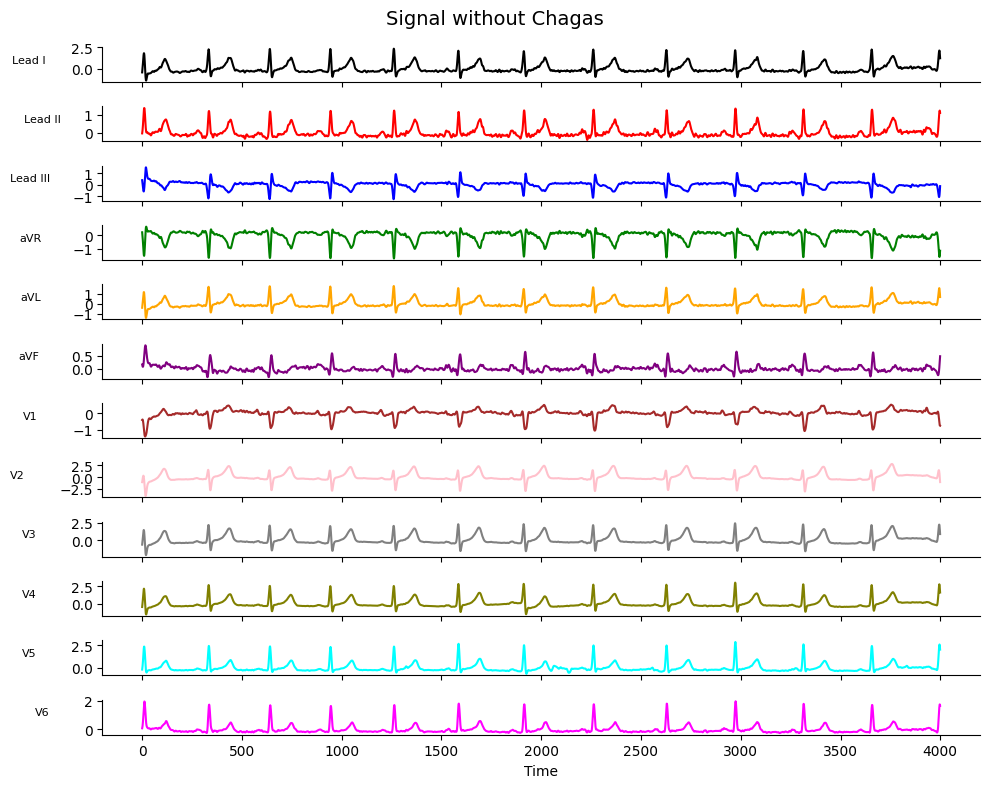

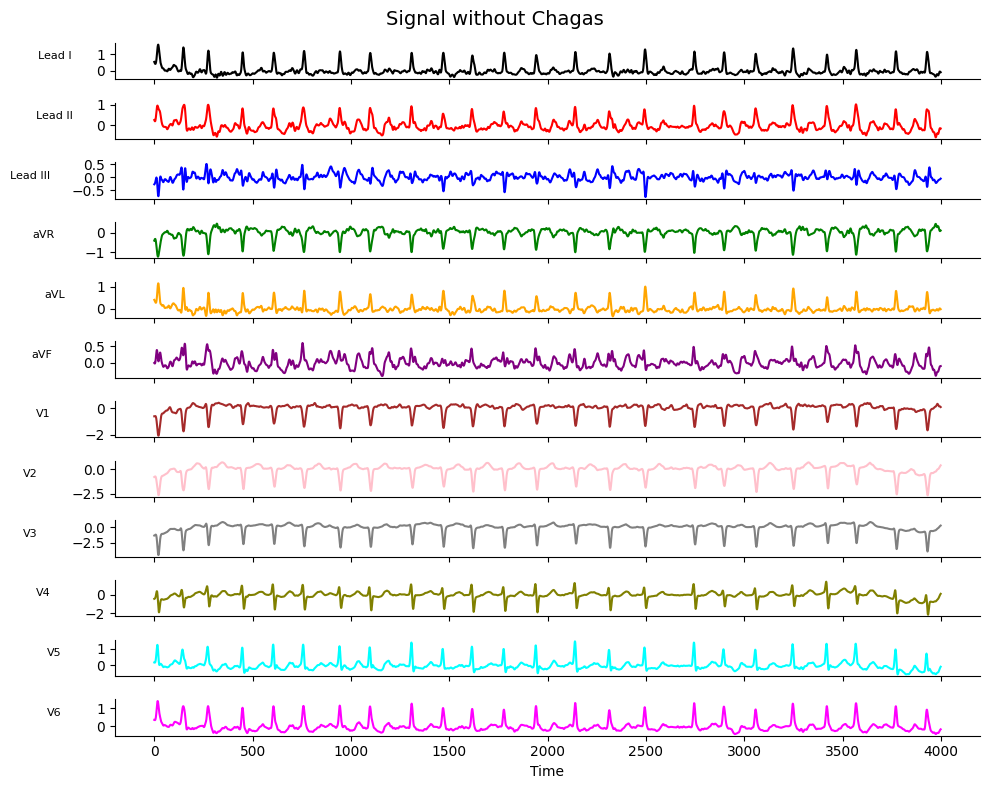

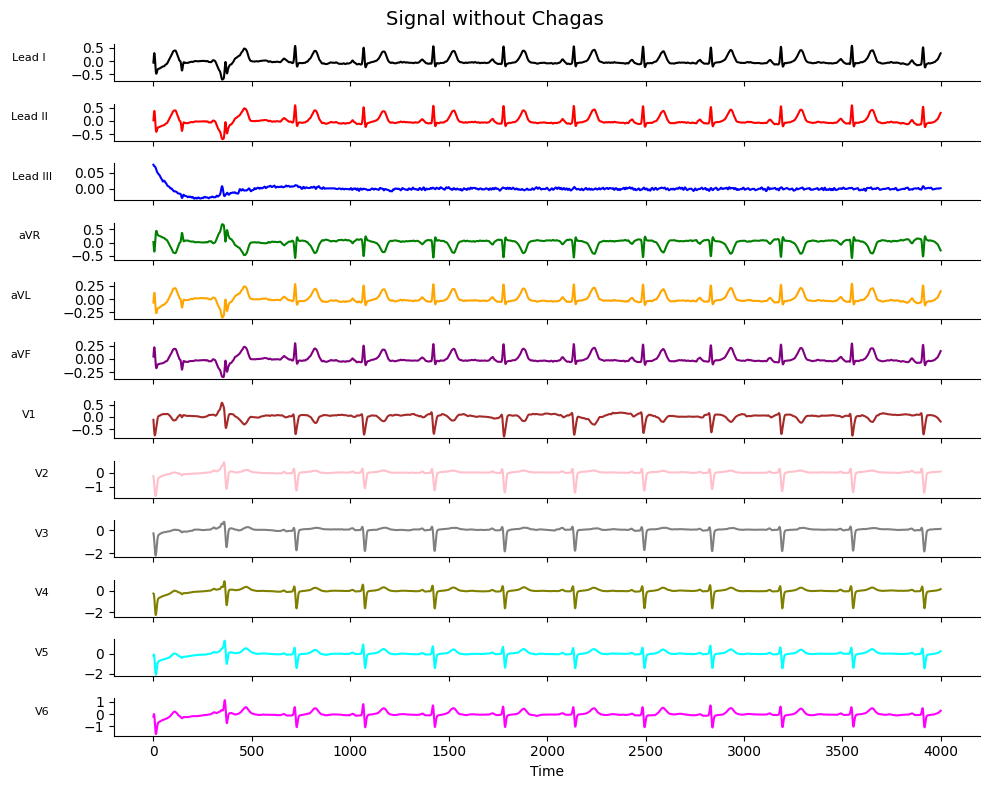

In [ ]:
banned_idx = [739, 4157, 4629,5510,6470,6896,7305]
for i in banned_idx:
    # save in npy
    np.save(f"ECG_example_{i}.npy", dataset[i][0].numpy())

In [3]:
for idx, (ecg, label) in enumerate(dataset):
    print(f"Processing instance {idx}")
    print(ecg.shape)
    break

Processing instance 0
torch.Size([4000, 12])


In [11]:
average_beats=np.array(average_beats)
average_beats.shape

(2, 12, 90)

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_12lead_ecg(avg_beats, instance_idx=0):
    """
    Plot all 12 leads for an averaged ECG beat.

    Parameters:
    - avg_beats: list of [leads x samples] arrays
    - instance_idx: which instance to plot (default: 0)
    """
    beat = avg_beats[instance_idx]
    
    if beat is None:
        print(f"No beat data available for instance {instance_idx}.")
        return
    
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 
                  'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    
    leads = beat.shape[0]
    time = np.arange(beat.shape[1])

    fig, axs = plt.subplots(6, 2, figsize=(12, 10))
    axs = axs.flatten()

    for lead in range(leads):
        axs[lead].plot(time, beat[lead, :], color='b')
        axs[lead].set_title(f'Lead {lead_names[lead]}')
        axs[lead].set_xlabel('Sample')
        axs[lead].set_ylabel('Amplitude')
        axs[lead].grid(True)

    plt.tight_layout()
    plt.suptitle(f'Average ECG Beat - Instance {instance_idx}', fontsize=16, y=1.02)
    plt.show()


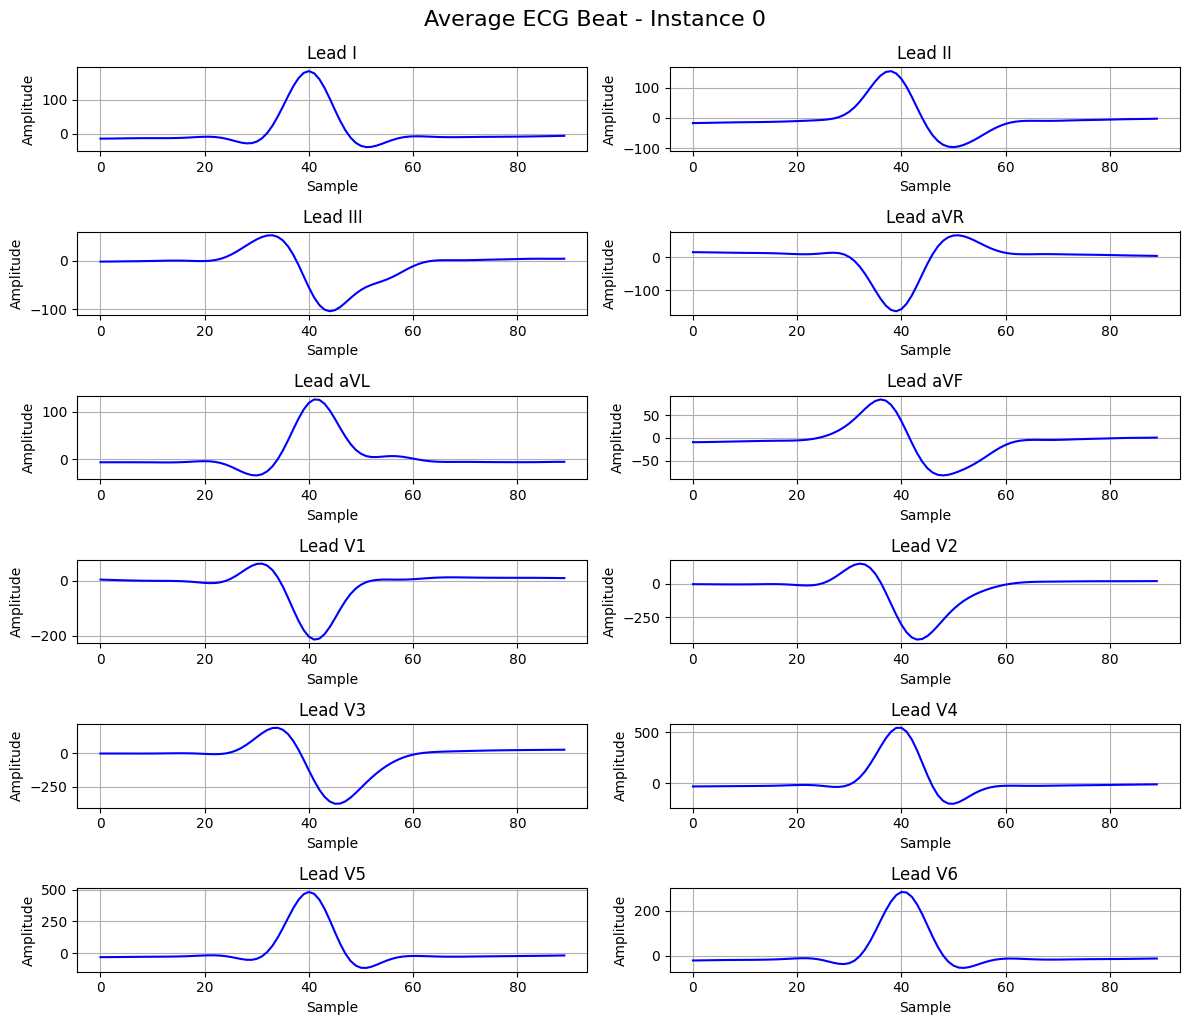

In [21]:
plot_12lead_ecg(average_beats, instance_idx=0)
